I am a newbie and this is the code that was created by the user: inversion.
Would love comments and if anything looks improperly explained, please let me know in the comments.
thanks!

In this competition, you will address when the earthquake will take place. Specifically, you’ll predict the time remaining before laboratory earthquakes occur from real-time seismic data.

How is the data generated?
- The data are from an experiment conducted on rock in a double direct shear geometry subjected to bi-axial loading, a classic laboratory earthquake model. (fig. a)
- Two fault gouge layers are sheared simultaneously while subjected to a constant normal load and a prescribed shear velocity. The laboratory faults fail in repetitive cycles of stick and slip that is meant to mimic the cycle of loading and failure on tectonic faults. While the experiment is considerably simpler than a fault in Earth, it shares many physical characteristics. (fig. b)
- Los Alamos' initial work showed that the prediction of laboratory earthquakes from continuous seismic data is possible in the case of quasi-periodic laboratory seismic cycles. In this competition, the team has provided a much more challenging dataset with considerably more aperiodic earthquake failures.
- The seismic data is recorded using a piezoceramic sensor, which outputs a voltage upon deformation by incoming seismic waves. The seismic data of the input is this recorded voltage, in integers.
- The acoustic data shows the movement of the ground up (positive) and ground down (negative).

Published work on the topic is in the following papers:
- https://doi.org/10.1002/2017GL074677
- https://doi.org/10.1002/2017GL076708
- https://rdcu.be/bdG8Y
- https://rdcu.be/bdG9r

These predictions are based solely on the instantaneous physical characteristics of the acoustical signal and do not make use of its history.

In [ ]:
# Load package to display pictures and videos
from IPython.display import Audio, Image, YouTubeVideo

In [ ]:
# Display a video using the id which is the string between the = and & (if there is an &)
YouTubeVideo(id='m_dBwwDJ4uo', width=600, height=400)

In [ ]:
# Display a video using the id which is the string between the = and & (if there is an &)
YouTubeVideo(id='P7h0JfQ-oHg', width=600, height=400)

In [12]:
# Import specific packages and modules
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.metrics import mean_absolute_error

import os
print(os.listdir("../input"))

['test', 'train.csv', 'sample_submission.csv']


In [10]:
# Gives number of rows without loading the file first
! wc -l "../input/train.csv"

629145481 ../input/train.csv


In [14]:
# Load training data
# I used float32 and not float64 (like the example) since I did not have the memory for float64.
train = pd.read_csv("../input/train.csv", dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [15]:
# Display time_to_failure with more units of precision
pd.options.display.precision = 15

In [16]:
train.head()

,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121


In [17]:
# Break approximately 600 million rows up into 150K segments.
rows = 150_000

# Determine how many EQUAL segments to divide total dataset into.
# Following code takes the first [0] (or zero) column of the train data. Then divides by rows (or 150,000).
# Then rounds the value down (or floor). Then sets the value as an integer. 
segments = int(np.floor(train.shape[0] / rows))
print(segments)

4194


In [19]:
# Create an empty dataframe (X_train) which is the size of the dataset/ 150000 or 4194 with ave, std, max, min columns.
# Create another empty dataframe (y_train) with just the time to failure.
# For both dataframes, index is set as range of the segments.
# range() function returns a sequence of numbers with format range(start, stop, step) with start=1 and step=1 if not given
X_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['ave', 'std', 'max', 'min'])
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])

In [20]:
# Empty dataframe for X_train
X_train.head()

,ave,std,max,min
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


In [21]:
# Empty dataframe for y_train
y_train.head()

,time_to_failure
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [22]:
# Calculate all the values for each of the 4194 segments in the X_train dataframe (mean, std, max, min).

# tqdm make your loops show a smart progress meter

# iloc is integer-location based indexing for selection by position
# [segment*rows:segment*rows+rows] points to which data to apply calculation to
# loops through all segments starting at 0 to 150k then 150k to 300k, etc.
# For each segment, the mean, standard deviation, maximum and min are computed.

# Fill in the time values for the y_train dataframe. .values[-1] will point to the last time value in the 150,000 segment

for segment in tqdm(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = seg['acoustic_data'].values
    y = seg['time_to_failure'].values[-1]
    
    y_train.loc[segment, 'time_to_failure'] = y
    
    X_train.loc[segment, 'ave'] = x.mean()
    X_train.loc[segment, 'std'] = x.std()
    X_train.loc[segment, 'max'] = x.max()
    X_train.loc[segment, 'min'] = x.min()

100%|██████████| 4194/4194 [00:10<00:00, 384.69it/s]


In [23]:
# View the X_train dataframe after the engineered features added
X_train.head()

,ave,std,max,min
0,4.884113333333334,5.101089126891323,104.0,-98.0
1,4.725766666666667,6.588801819164257,181.0,-154.0
2,4.906393333333333,6.967373808828945,140.0,-106.0
3,4.902240000000000,6.922282112791032,197.0,-199.0
4,4.908720000000000,7.301085852684289,145.0,-126.0


In [24]:
# View the y_train dataframe after calculation applied to it.
y_train.head()

,time_to_failure
0,1.430797219276428
1,1.391498923301697
2,1.353196144104004
3,1.313797831535339
4,1.274399518966675


In [25]:
# Create a StandardScaler model called scaler.
# Normalize/standardize (mean = 0 and standard deviation = 1) features before applying machine learning techniques.
scaler = StandardScaler()

# fit will apply the scaler model to the dataframe (X_train in this case)
scaler.fit(X_train)

# transform will look at the dataframe columns one by one and return back a series (or group of series) 'made' of scalars
X_train_scaled = scaler.transform(X_train)
print(X_train_scaled)

[[ 1.4241405  -0.17021358 -0.21819351  0.19321819]
 [ 0.80571603  0.00473402  0.06393601 -0.01803727]
 [ 1.51115526  0.0492522  -0.0862888   0.16303883]
 ...
 [ 0.34265275 -0.39124963 -0.36841832  0.4157909 ]
 [-0.21161721 -0.28084016 -0.25483371  0.1969906 ]
 [-0.00415653 -0.37312925 -0.3647543   0.31393559]]


In [26]:
# Create a model Nu Support Vector Regression
# In simple regression we try to minimise the error rate. While in SVR we try to fit the error within a certain threshold.
# NuSVR allows you to limit the number of support vectors used.
# Create svm model and fit to the data
# .flatten will return a copy of the array collapsed into one dimension
svm = NuSVR()
svm.fit(X_train_scaled, y_train.values.flatten())

# Predict y (acoustic data) with the model
y_pred = svm.predict(X_train_scaled)
print(y_pred)# Create a model Nu Support Vector Regression
# In simple regression we try to minimise the error rate. While in SVR we try to fit the error within a certain threshold.
# NuSVR allows you to limit the number of support vectors used.
# Create svm model and fit to the data
# .flatten will return a copy of the array collapsed into one dimension
svm = NuSVR()
svm.fit(X_train_scaled, y_train.values.flatten())

# Predict y (acoustic data) with the model
y_pred = svm.predict(X_train_scaled)
print(y_pred)

[6.54201231 4.69066738 4.42778471 ... 8.82072262 7.64065766 8.67662095]
[6.54201231 4.69066738 4.42778471 ... 8.82072262 7.64065766 8.67662095]


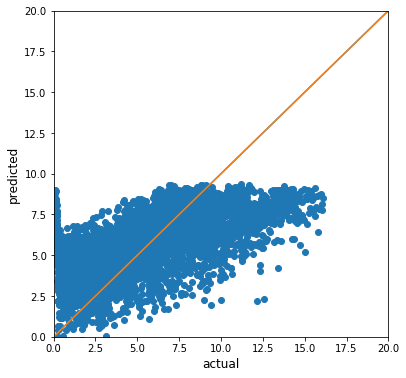

In [27]:
# Plot y actual vs y predicted
# Orange diagonal line is point of reference to compare acutal (on x-axis) vs predicted (on y-axis)
plt.figure(figsize=(6, 6))
plt.scatter(y_train.values.flatten(), y_pred)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

In [28]:
# Determine the score of the model
score = mean_absolute_error(y_train.values.flatten(), y_pred)
print(f'Score: {score:0.3f}')

Score: 2.314


In [31]:
# Read in the blank sample submission file
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission.head()

,time_to_failure
seg_id,
seg_00030f,0
seg_0012b5,0
seg_00184e,0
seg_003339,0
seg_0042cc,0


In [32]:
# Prepare the dataframe for the test segments so can apply svm model
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)
X_test.head()

,ave,std,max,min
seg_id,,,,
seg_00030f,NaN,NaN,NaN,NaN
seg_0012b5,NaN,NaN,NaN,NaN
seg_00184e,NaN,NaN,NaN,NaN
seg_003339,NaN,NaN,NaN,NaN
seg_0042cc,NaN,NaN,NaN,NaN


In [34]:
# Read in each test segment, apply engineered features and put in dataframe.
for seg_id in X_test.index:
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    
    x = seg['acoustic_data'].values
    
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()

X_test.head()

,ave,std,max,min
seg_id,,,,
seg_00030f,4.491780000000000,4.893673374701939,115.0,-75.0
seg_0012b5,4.171153333333334,5.922819700375451,152.0,-140.0
seg_00184e,4.610260000000000,6.946966920827151,248.0,-193.0
seg_003339,4.531473333333333,4.114132889113924,85.0,-93.0
seg_0042cc,4.128340000000000,5.797144312308719,177.0,-147.0


In [39]:
# Apply the model to the X_test dataframe by scaling then transforming it.
X_test_scaled = scaler.transform(X_test)
submission['time_to_failure'] = svm.predict(X_test_scaled)

# Prepare submission for Kaggle
# Best to use date and submssion
submission.to_csv('submission_one_04_15.csv')